In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Covid-19 SG dataset details

sheet_id = "1gFTNs_GtnTIyyVWXmsQxwdZpGbyicZM2HJcXvCf4b3k"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

In [3]:
# read Covid-19 SG dataset

sg_data = pd.read_csv(url)

In [4]:
# filter to include only columns A to AD

sg_data_filtered = sg_data.iloc[:, :30]

# EDA & Pre-processing

**Outliers will not be removed because of their importance in the Covid context.**

**No need for scaling as all features are of the same magnitude.**

**Can look into what other features can be included from the current ones through extrapolation.**

In [5]:
sg_data_filtered.head()

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,...,Total Hospital Discharged MOH report,Requires Oxygen Supplementation,Linked community cases,Unlinked community cases,Phase,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination
0,2020-01-23,1,NaN,1,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-24,2,NaN,3,0,0,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-25,1,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-26,0,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-27,1,NaN,5,0,0,0,0,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Date                                          620 non-null    object 
 1   Daily Confirmed                               620 non-null    int64  
 2   False Positives Found                         511 non-null    float64
 3   Cumulative Confirmed                          620 non-null    int64  
 4   Daily Discharged                              620 non-null    int64  
 5   Passed but not due to COVID                   620 non-null    int64  
 6   Cumulative Discharged                         620 non-null    int64  
 7   Discharged to Isolation                       620 non-null    int64  
 8   Still Hospitalised                            620 non-null    int64  
 9   Daily Deaths                                  620 non-null    int

In [7]:
# convert date to columns: year, month, day before dropping date column

sg_data_filtered["Date"] = pd.to_datetime(sg_data_filtered["Date"])
sg_data_filtered["Year"] = sg_data_filtered["Date"].dt.year
sg_data_filtered["Month"] = sg_data_filtered["Date"].dt.month
sg_data_filtered["Day"] = sg_data_filtered["Date"].dt.day
sg_data_filtered.drop("Date", axis=1, inplace=True)

In [8]:
# convert NaN values for phase to None

sg_data_filtered["Phase"] = sg_data_filtered["Phase"].fillna("None")

In [9]:
# change to one-hot dummy for phase

sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1).drop('Phase', axis = 1)

In [10]:
# convert percentage for Perc population completed at least one dose & Perc population completed vaccination

sg_data_filtered["Perc population completed at least one dose"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed at least one dose"]]
sg_data_filtered["Perc population completed vaccination"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed vaccination"]]

In [11]:
# convert all NaN values present to zeros for the rest of the columns (if data is unavailable, just treat as 0)

sg_data_filtered.fillna(0, inplace=True)

In [12]:
# check to see if NaN values still present

sg_data_filtered.isnull().values.any()

False

In [13]:
# check column info after pre-processing

sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Daily Confirmed                               620 non-null    int64  
 1   False Positives Found                         620 non-null    float64
 2   Cumulative Confirmed                          620 non-null    int64  
 3   Daily Discharged                              620 non-null    int64  
 4   Passed but not due to COVID                   620 non-null    int64  
 5   Cumulative Discharged                         620 non-null    int64  
 6   Discharged to Isolation                       620 non-null    int64  
 7   Still Hospitalised                            620 non-null    int64  
 8   Daily Deaths                                  620 non-null    int64  
 9   Cumulative Deaths                             620 non-null    int

<AxesSubplot:>

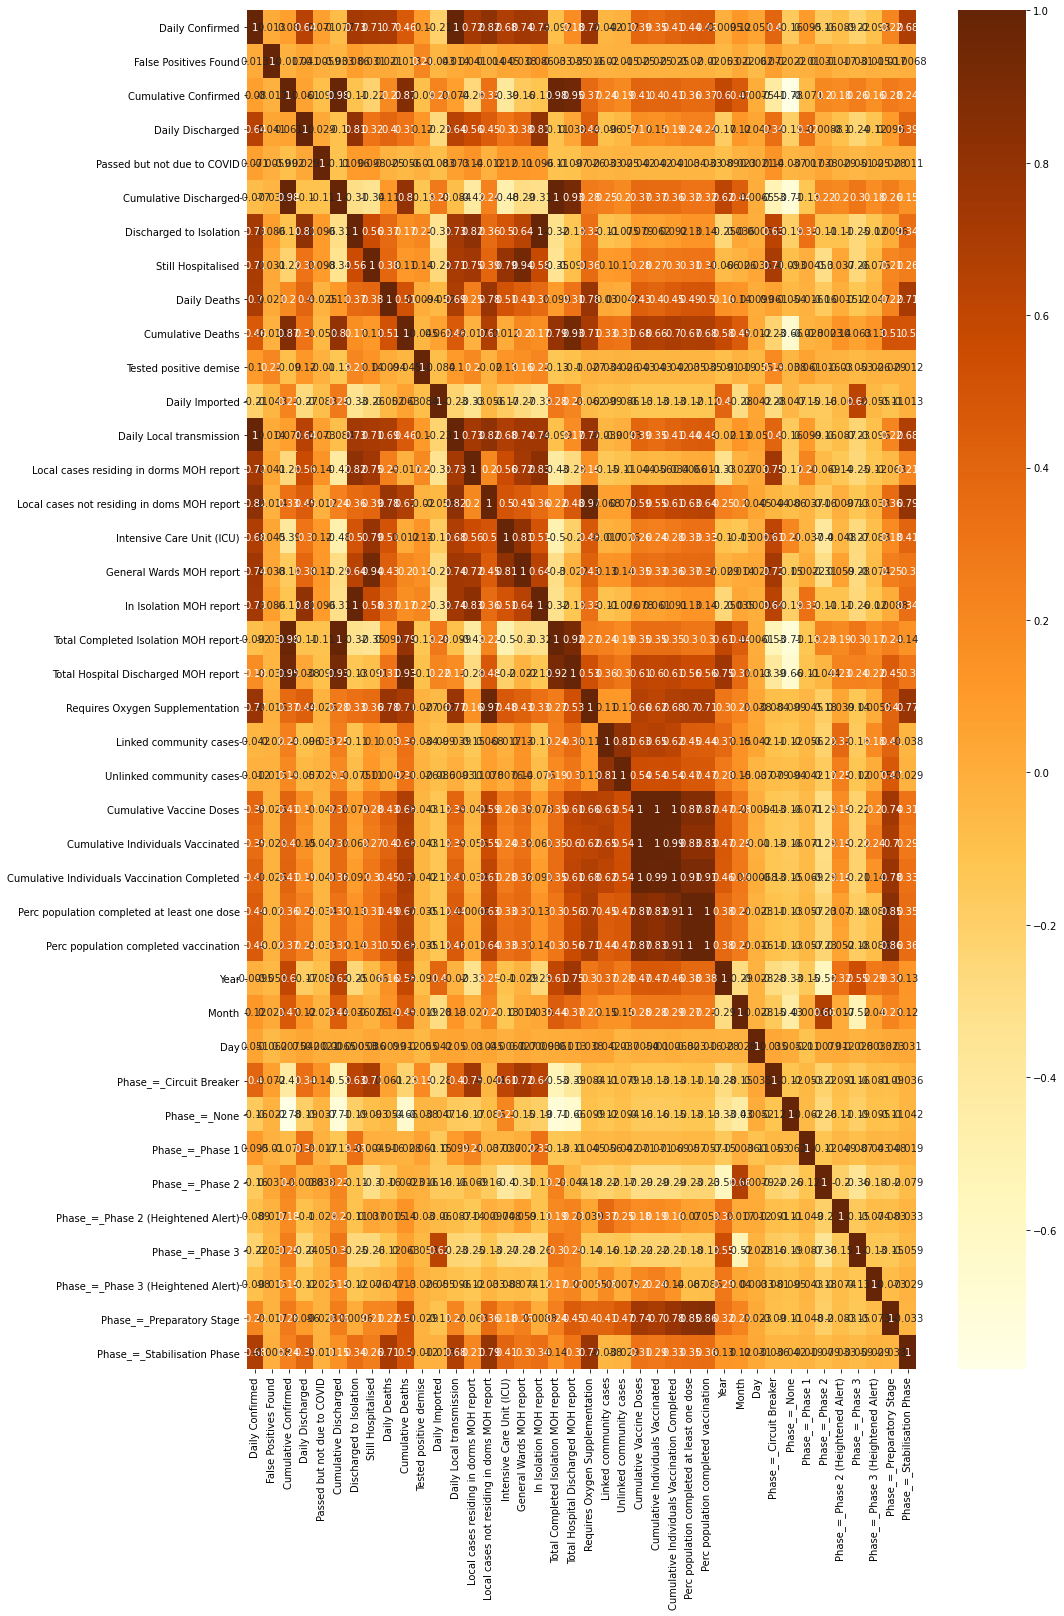

In [14]:
# corr. heatmap

plt.figure(figsize=(15,25))
sns.heatmap(sg_data_filtered.corr(), cmap='YlOrBr', annot=True)

In [15]:
# understanding correlation of all variables to imported cases (can change accordingly to the variable you are trying to predict)

sg_data_filtered.corr()["Daily Imported"].sort_values(ascending=False)

Daily Imported                                  1.000000
Phase_=_Phase 3                                 0.624731
Year                                            0.395002
Total Completed Isolation MOH report            0.282577
Cumulative Discharged                           0.279871
Cumulative Confirmed                            0.221414
Total Hospital Discharged MOH report            0.217089
Cumulative Deaths                               0.063458
Day                                             0.042206
Phase_=_Stabilisation Phase                    -0.012714
False Positives Found                          -0.043128
Phase_=_None                                   -0.047278
Daily Deaths                                   -0.052005
Phase_=_Phase 3 (Heightened Alert)             -0.055478
Local cases not residing in doms MOH report    -0.055841
Phase_=_Phase 2 (Heightened Alert)             -0.059699
Requires Oxygen Supplementation                -0.062144
Passed but not due to COVID    

In [16]:
# conduct PCA on preprocessed columns

# pca = PCA().fit(sg_data_filtered)

In [17]:
# pca.components_[0]

In [18]:
# find index of columns that make most contribution to variance captured

# include index of Daily Imported first
# important_indices = [11]

# for i in range(len(pca.components_[0])):
#     curr_comp = pca.components_[0][i]
#     if curr_comp > 0.0001:
#         important_indices.append(i)

In [19]:
# select the columns that are positively correlated to imported cases + PCA columns

# sg_data_final = sg_data_filtered.iloc[:, important_indices]

# Train Test Split

In [20]:
# change y variable accordingly to what is of interest

X = sg_data_filtered.drop("Daily Imported", axis=1)
y = sg_data_filtered["Daily Imported"]

In [21]:
# split using 25% for test as amount of data isn't much so that we've got more points to test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Linear Regression

In [22]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [23]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")

Evaluation Metrics for LR
MAE: 2.496022018069296e-11
MSE: 1.973300246651119e-21
RMSE: 4.442184425089889e-11
R-squared score for train: 1.0
Adjusted R-squared score for train: 1.0
R-squared score for test: 1.0
Adjusted R-squared score for test: 1.0


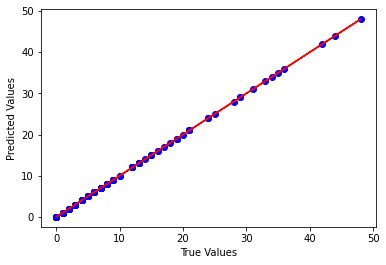

In [24]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

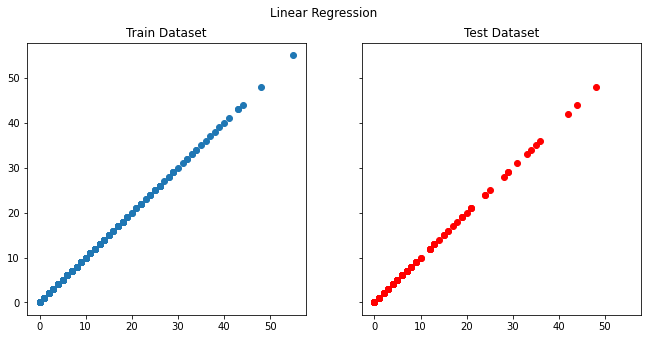

In [25]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [26]:
# find out feature importance

regr_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': regression.coef_
})

regr_importance = regr_importance.sort_values(by='Importance', ascending=False)
regr_importance

,Attribute,Importance
0,Daily Confirmed,1.000000e+00
4,Passed but not due to COVID,1.314464e-10
10,Tested positive demise,7.340147e-11
9,Cumulative Deaths,1.949607e-11
6,Discharged to Isolation,9.739702e-12
7,Still Hospitalised,9.736311e-12
5,Cumulative Discharged,9.331208e-12
19,Requires Oxygen Supplementation,2.016571e-12
21,Unlinked community cases,6.416594e-13
35,Phase_=_Phase 3,3.580095e-13


# Lasso Regression

In [27]:
# build lasso model

lasso = Lasso(max_iter=10000)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1128.9603326209017, tolerance: 4.11301806451613
  model = cd_fast.enet_coordinate_descent(


In [28]:
# assessing model

train_adjusted_r2 = 1 - (1-lasso.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-lasso.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Lasso")
print(f"MAE: {mean_absolute_error(y_test, lasso_pred)}")
print(f"MSE: {mean_squared_error(y_test, lasso_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, lasso_pred))}")
print(f"R-squared score for train: {lasso.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {lasso.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")

Evaluation Metrics for Lasso
MAE: 0.5916784218857885
MSE: 1.6644648803254303
RMSE: 1.2901414187310747
R-squared score for train: 0.9927413977818295
Adjusted R-squared score for train: 0.9922533193568145
R-squared score for test: 0.9817541184536751
Adjusted R-squared score for test: 0.9805272402117671


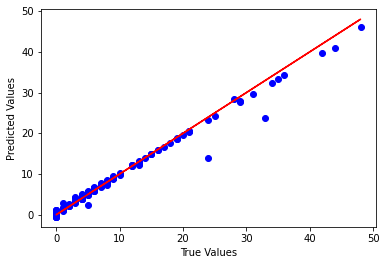

In [29]:
# For test set

# scatter for predictions
plt.scatter(y_test, lasso_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

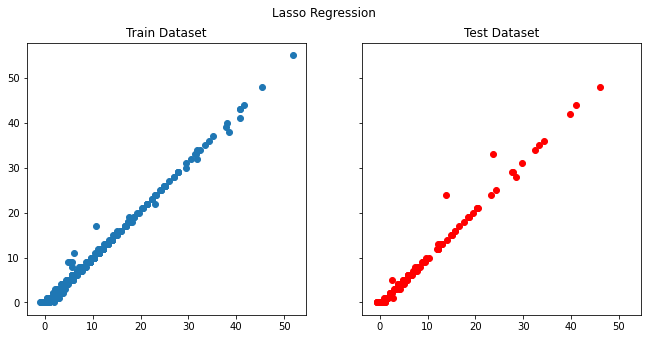

In [30]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(lasso.predict(X_train), y_train)
ax[1].scatter(lasso_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Lasso Regression')

plt.show()

In [31]:
# find out feature importance

lasso_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': lasso.coef_
})

lasso_importance = lasso_importance.sort_values(by='Importance', ascending=False)
lasso_importance

,Attribute,Importance
0,Daily Confirmed,0.924681
16,In Isolation MOH report,0.050253
15,General Wards MOH report,0.049496
5,Cumulative Discharged,0.002218
22,Cumulative Vaccine Doses,0.000002
29,Day,-0.000000
25,Perc population completed at least one dose,0.000000
26,Perc population completed vaccination,0.000000
27,Year,0.000000
28,Month,-0.000000
